In [2]:
# 设计一些toy data example去支撑我们的设计
# ①假设一：使用方形网格设计（后续可以改成六边形，其实也不一定有必要）
# ② 假设二：区域设定为6公里 × 6公里，设定一个合理的骑手速度，骑手量与订单量（骑手量和订单量可以作为变量调节）
# ③ 假设三：区域6km × 6km，网格300m × 300m，形成一个20 × 20 = 400的网格区域，纬度为30.70 -- 30.76,经度121.10--121.16，
#一个小区域0.0005 × 0.0005，比如30.70 --30.703,121.10 -- 121.103。即0.06为6km，0.003为300m。
# ④ 假设四：骑手速度：12.11km/h,200m/min。这样跑一个对角需要42min，差不多。

### 丁一学长给的经纬度对应关系

In [3]:
# The following is the lat/lon area I used to cover Shanghai.
# AND latitude > 30.7 AND latitude < 31.5
# AND longitude > 121.1 AND longitude < 121.9

# The following is the mapping between grid ID and lat/lon.
# ((FLOOR(t1.latitude*100)-3070)*80+(FLOOR(t1.longitude*100)-12110)) AS grid_id

### 头文件区

In [4]:
from math import sin, asin, cos, radians, fabs, sqrt
EARTH_RADIUS = 6371  # 地球平均半径，6371km
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

### 函数区

In [5]:
def hav(theta):
    s = sin(theta / 2)
    return s * s


def get_distance_hav(lat0, lng0, lat1, lng1):
    """
     用haversine公式计算球面两点间的距离
    """
    # 经纬度转换成弧度
    lat0 = radians(lat0)
    lat1 = radians(lat1)
    lng0 = radians(lng0)
    lng1 = radians(lng1)

    dlng = fabs(lng0 - lng1)
    dlat = fabs(lat0 - lat1)
    h = hav(dlat) + cos(lat0) * cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * asin(sqrt(h))

    return round(distance * 1000)

In [6]:
get_distance_hav(30.70,121.10,30.703,121.10)

334

 ### 确定有多少家商家，多少个骑手，多少个订单

In [7]:
# 区域: latitude:30.70--30.76    longitude: 121.10 -- 121.16    6000m 300m  200m/min

In [8]:
# 将区域分为四个部分：高商高顾（CBD），高商低顾（商业区），低商高顾（居民区），低商低顾（郊区）

In [9]:
# 派单区域按照网格来算，每五分钟更新骑手所在的位置和所在的网格，如果骑手在更新时还没有收到新订单，他会前往最近的CBD区和商业区。

In [10]:
# 每五分钟派一次单，即每五分钟更新一次骑手的状态，骑手的状态分为三种(配送中，等待中，回程中)，
#配送中会记录处在哪个区域内，还有多久离开这个区域，下一个区域名称。
# 等待中会记录处在哪个区域中，还有多少等待时间。
# 回程中会记录处在哪个区域内，还有多久离开这个区域，下一个区域名称。
# 骑手前往临近区域只有两种，直行/斜行，直行300m花费1.5min，斜行400m花费2min。
# 骑手会记录一个路径，在派单的过程中会持续记录路径

In [11]:
# 29个CBD，44个商业区，91个居民区，236个郊区。
# 400个区域，293个商家，1000个骑手，n个订单（订单平均长度3500m，每个骑手每小时一定能处理3单）

#### 确定每个区域的类型

In [12]:
# 区域的编号为：x + 20*y  (x,y都是0-19)

In [13]:
# 0 1 1 2
# 2 2 1 3
# 2 3 4 2
# 1 2 1 2
CBDList = []
# 1 2 1 2
# 2 3 2 5
# 2 3 8 1
# 2 5 3 2
commerceList = []
# 3 6 3 5
# 4 6 5 7
# 6 7 12 4
# 5 6 5 7
residentList = []
# 22 16 20 16 
# 17 14 17 10
# 15 12 1 18
# 17 12 16 14
suburbList = []

In [14]:
CBDNumList =      [ 0, 1, 1, 2, 2, 2, 1, 3, 2, 3, 4, 2, 1, 2, 1, 2]
commerceNumList = [ 1, 2, 1, 2, 2, 3, 2, 5, 2, 3, 8, 1, 2, 5, 3, 2]
residentNumList = [ 3, 6, 3, 5, 4, 6, 5, 7, 6, 7,12, 4, 5, 6, 5, 7]
suburbNumList =   [21,16,20,16,17,14,17,10,15,12, 1,18,17,12,16,14]
numList = [CBDNumList,commerceNumList,residentNumList,suburbNumList]

In [59]:
import random
fourDistrictType = [30,44,85,241]
nodeList = []
for x in range(4):
    for y in range(4):
        xList = list(range(x*5,x*5+5))
        yList = list(range(y*5,y*5+5))
        nodeDistrictList = []
        for nodex in xList:
            for nodey in yList:
                nodeDistrictList.append(nodex * 20 + nodey)
        nodeDistrictList = list(sorted(nodeDistrictList))
        nodeList.append(nodeDistrictList)
        
nodeTypeList = []  # 有四个子list，分别装四个区域对应的node编号

for i in range(4):
    districtNumList = numList[i] # 每种类型在小区域内的数
    tempNodeList = [] # 记录更新后的node
    tempNodeTypeList = [] # 记录单个区域对应的node编号
    for j in range(16):
        districtNumTypeList = random.sample(nodeList[j],districtNumList[j]) # 从nodelist中随机选择一些数
        tempNode = []
        for node in nodeList[j]:
            if node not in districtNumTypeList:
                tempNode.append(node)
        tempNodeList.append(tempNode) # 更新后的nodelist
        tempNodeTypeList.append(districtNumTypeList)
    nodeList = tempNodeList
    tempNodeTypeList = [x for y in tempNodeTypeList for x in y]
    tempNodeTypeList = sorted(tempNodeTypeList)
    nodeTypeList.append(tempNodeTypeList)

In [60]:
# nodelist 包含16个小区域的编号
# numList 为每种类型在16个小区域内的数
# nodeTypeList 包含每种类型的编号

In [61]:
# 将网格内的区域进行可视化

In [62]:
# 将nodeTypeList转化成0-1矩阵的形式

In [63]:
nodeTypeMatrix = [0] * 400
for i in range(4):
    for num in nodeTypeList[i]:
        nodeTypeMatrix[num] = i
nodeTypeMatrix = np.array(nodeTypeMatrix).reshape(20,20)

In [64]:
nodeTypeMatrix = list(nodeTypeMatrix)

In [65]:
# 紫色为CBD区，高merchant高customer
# 蓝色为饮食区，高merchant低customer
# 绿色为居民区，低merchant高customer
# 黄色为郊区，低merchant低customer

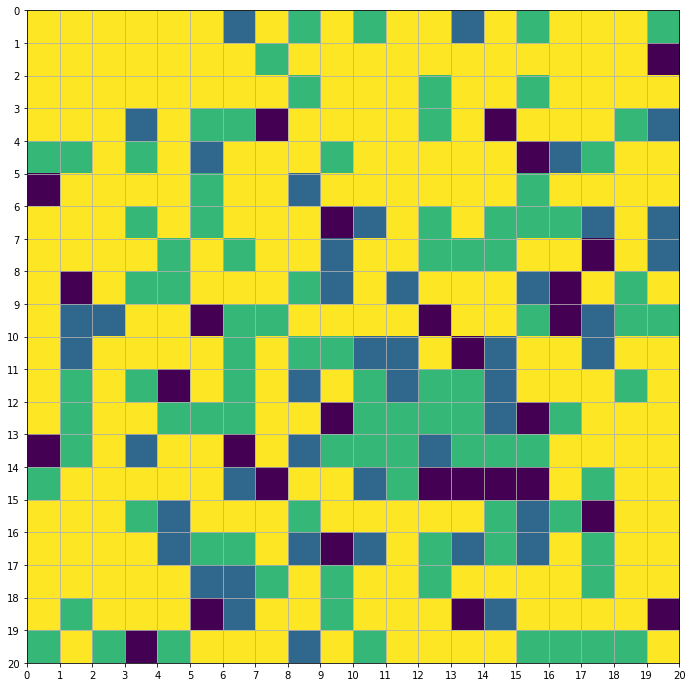

In [66]:
plt.figure(figsize = (12,12))
plt.yticks(np.arange(-0.5,20.5,1),np.arange(0,21,1))
plt.xticks(np.arange(-0.5,20.5,1),np.arange(0,21,1))
plt.grid(True)
plt.imshow(nodeTypeMatrix)
# plt.savefig('./DataSave/nodeTypePicture.png')

In [67]:
# with open('./DataSave/nodeTypeMatrix.pkl','wb') as fw:
#    pickle.dump(nodeTypeMatrix,fw)

In [68]:
# with open('./DataSave/nodeTypeList.pkl','wb') as fw:
#   pickle.dump(nodeTypeList,fw)

#### 确定商家位置与订单顾客位置

In [69]:
# 一天大概3万单，生成一个月的订单约100万。
# 对于每个订单，需要考虑两个问题，它产生在哪里，它又被送到了哪里
# 对于每个区域的订单，如果派单范围内没有人接收，它将被取消，如果范围内有人，那它一定要被派出去。
# 骑手被派到居民区或郊区如果没有单会自动形成一条去CBD或商业区的路，去最近的CBD或者商业区。

In [70]:
# 订单：CBD区 45% 商业区 40% 居民区 10%  郊区：5%
# 送达：CBD区 30% 商业区 10%  居民区：50% 郊区：10%

In [71]:
#nodeTypeMatrix = open('./DataSave/nodeTypeMatrix.pkl','rb')
#nodeTypeMatrix = pickle.load(nodeTypeMatrix)

In [72]:
#nodeTypeList = open('./DataSave/nodeTypeList.pkl','rb')
#nodeTypeList = pickle.load(nodeTypeList)

In [73]:
# 用概率来解决问题
# 每一个订单产生，它的商家在哪里，它的顾客又在哪里，这两者离多远？
# 如何确定订单产生的商家？40% 40% 15% 5% 产生概率，然后在内部进行随机平均产生
# 如何确定订单配送的位置？35% 10% 50% 5% 但距离会对订单配送位置产生影响，距离<5 45%  5<x<10  45%   >10 10%
# 所以需要给每一个node记录，记录node距离它的四种类型的[]

In [74]:
nodeTypeMatrix = np.array(nodeTypeMatrix)

In [75]:
# 3 郊区  2 居民区  1 消费区  0 CBD

In [76]:
nodeTypeMatrix

array([[3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 1, 3, 2, 3, 3, 3, 2],
       [3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0],
       [3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3],
       [3, 3, 3, 1, 3, 2, 2, 0, 3, 3, 3, 3, 2, 3, 0, 3, 3, 3, 2, 1],
       [2, 2, 3, 2, 3, 1, 3, 3, 3, 2, 3, 3, 3, 3, 3, 0, 1, 2, 3, 3],
       [0, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3],
       [3, 3, 3, 2, 3, 2, 3, 3, 3, 0, 1, 3, 2, 3, 2, 2, 2, 1, 3, 1],
       [3, 3, 3, 3, 2, 3, 2, 3, 3, 1, 3, 3, 2, 2, 2, 3, 3, 0, 3, 1],
       [3, 0, 3, 2, 2, 3, 3, 3, 2, 1, 3, 1, 3, 3, 3, 1, 0, 3, 2, 3],
       [3, 1, 1, 3, 3, 0, 2, 2, 3, 3, 3, 3, 0, 3, 3, 2, 0, 1, 2, 2],
       [3, 1, 3, 3, 3, 3, 2, 3, 2, 2, 1, 1, 3, 0, 1, 3, 3, 1, 3, 3],
       [3, 2, 3, 2, 0, 3, 2, 3, 1, 3, 2, 1, 2, 2, 1, 3, 3, 3, 2, 3],
       [3, 2, 3, 3, 2, 2, 2, 3, 3, 0, 2, 2, 2, 2, 1, 0, 2, 3, 3, 3],
       [0, 2, 3, 1, 3, 3, 0, 3, 1, 2, 2, 2, 1, 2, 2, 2, 3, 3, 3, 3],
       [2, 3, 3, 3, 3, 3, 1, 0, 3,

In [105]:
class Node:
    def __init__(self,num,x,y):
        self.nodeType = num
        self.nodeNum = y + 20 * x
        self.nodeCoord = (x,y)
        self.sixNode= [[],[],[],[]]  # 距离Node小于等于6的节点距离(4,3) 30%
        self.twelveNode = [[],[],[],[]]  # 距离Node距离大于6小于等于12的节点距离(8,6) 40%
        self.moreNode = [[],[],[],[]] # 距离Node距离大于12的节点距离 30%
    
    def nodePrint(self):
        print('结点坐标:' + str(self.nodeCoord))

In [106]:
nodeList = []
for i in range(20):
    for j in range(20):
        node = Node(nodeTypeMatrix[i,j],i,j)
        nodeList.append(node)
nodeMatrix = np.array(nodeList).reshape(20,20)

In [107]:
# 距离计算函数
# 返回路径函数

In [108]:
# 骑手速度：200m/min
# 1格距离：300m, 1.5min
# 2格距离：2min
# 骑手只能选择走周围八个格子

def count_distance(coordone,coordtwo):
    (x1,y1) = coordone  
    (x2,y2) = coordtwo
    x = abs(x1-x2)
    y = abs(y1-y2)
    return 1.5 * (max(x,y) - min(x,y)) + 2 * min(x,y)

In [109]:
# 遍历每一个节点，记录三个区域的四种状态

In [110]:
for i in range(20):
    for j in range(20):
        # 遍历每个节点，给每个节点分配对应的节点信息
        oriNode = nodeMatrix[i][j]  # 需要考虑的节点
        for k in range(400):
            x_cor = int(k/20)
            y_cor = int(k%20)
            testNode = nodeMatrix[x_cor,y_cor]  # 每一个测试的节点
            testNodeType = testNode.nodeType
            distance = count_distance(oriNode.nodeCoord,testNode.nodeCoord)
            if distance <= 6:
                oriNode.sixNode[testNodeType].append(testNode)
            elif distance > 6 and distance <= 12:
                oriNode.twelveNode[testNodeType].append(testNode)
            else:
                oriNode.moreNode[testNodeType].append(testNode)

In [ ]:
# 按概率生成订单，并生成送达的目的地(时间+起终点)
# 三十天订单，每天确定一个波动值的量，然后一天从早上8点到晚上10点将一天分为180个时段，每个时段5min，每个时段有一个基数进行波动
# 每天大约产生15000~25000订单，订单会有一个上升的波动

In [ ]:
testData = pd.read_csv('../2020-10-12中环数据.csv')

In [ ]:
Time = pd.DataFrame(testData['order_create_time'])
Time['order_create_time'] = pd.to_datetime(Time['order_create_time'],format = '%Y/%m/%d %H:%M')
Time['hour'] = Time['order_create_time'].apply(lambda x:x.hour)

In [ ]:
Time.hour.value_counts()

In [ ]:
numlist = [1551,1799,5528,13402,6512,3302,2243,1844,2054,2948,2976,2101,1428,990,772]

In [ ]:
sumnumlist = sum(numlist)
perlist = [0] * len(numlist)
for i in range(len(numlist)):
    perlist[i] = round(numlist[i]/sumnumlist,4)

In [ ]:
perlist

In [ ]:
# 30天为20000单上下30%波动

In [ ]:
origindaynumlist = []
for i in range(30):
    num = round(20000 * (1 + (random.random()* 0.6 - 0.3)))
    origindaynumlist.append(num)

In [ ]:
origindaynumlist

In [ ]:
#对于一天的订单量要将它们分摊到180个时间段内，且需要有一定的波动性(先分15个，再分12个)

In [ ]:
wholenumlist=[] # 30 + 15 + 12
for i in range(30):
    originlist = [per*origindaynumlist[i] for per in perlist]
    originlist = [round(originnum) for originnum in originlist]  # 每天原始的每小时的订单，由真实数据概率生成
    daynumlist = []
    for j in range(15):
        originlist[j] = round(originlist[j] * (random.random() * 0.2 + 0.9))
        slotnumlist = []
        # 特殊考虑时间段一：10-13
        # 特殊考虑时间段二：16-19
        # 剩下时间点保持不变
        if j == 2:
            wholenum = originlist[2] + originlist[3] + originlist[4] + originlist[5]
            beginnum = (originlist[1] * 0.08)
            endnum = (originlist[6] * 0.08) 
            highnum = (wholenum - 9*beginnum - 15*endnum)/24
            for k in range(48):
                if k <= 17:
                    num = beginnum + (highnum - beginnum) * (k/17)
                    slotnumlist.append(round(num * (random.random()*0.6 + 0.7)))
                else:
                    num = endnum + (highnum - endnum) * ((47-k)/30)
                    slotnumlist.append(round(num * (random.random()*0.6 + 0.7)))
        elif j == 8:
            wholenum = originlist[8] + originlist[9] + originlist[10] + originlist[11]
            beginnum = (originlist[7] * 0.08)
            endnum = (originlist[12] * 0.08) 
            highnum = (wholenum - 9*beginnum - 15*endnum)/24
            for k in range(48):
                if k <= 17:
                    num = beginnum + (highnum - beginnum) * k/17
                    slotnumlist.append(round(num * (random.random()*0.6 + 0.7)))
                else:
                    num = endnum + (highnum - endnum) * ((47-k)/30)
                    slotnumlist.append(round(num * (random.random()*0.6 + 0.7)))
        elif j in [3,4,5,9,10,11]:
            continue
        else:
            for k in range(12):
                slotnumlist.append(round(originlist[j] * 0.08 * (random.random()*0.6 + 0.7)))
        if len(slotnumlist) == 48:
            daynumlist.append(slotnumlist[:12])
            daynumlist.append(slotnumlist[12:24])
            daynumlist.append(slotnumlist[24:36])
            daynumlist.append(slotnumlist[36:])
        else:
            daynumlist.append(slotnumlist)
    wholenumlist.append(daynumlist)

In [ ]:
# 对于每一个订单，开始分配起终点

In [ ]:
# 用概率来解决问题
# 每一个订单产生，它的商家在哪里，它的顾客又在哪里，这两者离多远？
# 如何确定订单产生的商家？40% 40% 15% 5% 产生概率，然后在内部进行随机平均产生
# 如何确定订单配送的位置？35% 10% 50% 5% 但距离会对订单配送位置产生影响，距离<6 30%  6<x<12  40%   >12 30%
# 所以需要给每一个node记录，记录node距离它的四种类型的[]

In [ ]:
nodeTypeList0 = []
nodeTypeList1 = []
nodeTypeList2 = []
nodeTypeList3 = []
for x in nodeMatrix:
    for y in x:
        if y.nodeType == 0:
            nodeTypeList0.append(y)
        elif y.nodeType == 1:
            nodeTypeList1.append(y)
        elif y.nodeType == 2:
            nodeTypeList2.append(y)
        else:
            nodeTypeList3.append(y)
nodeList = [nodeTypeList0,nodeTypeList1,nodeTypeList2,nodeTypeList3]

In [ ]:
num = 0
finalOrderList = []
for i in range(30):  # 每一天
    onedayOrderList = []
    for j in range(15):  # 每个小时
        for k in range(12): # 每个时段
            oneslotOrderList = []
            orderNum = wholenumlist[i][j][k]
            while orderNum >= 0:
                ID = num
                day = i  # 订单天数
                time = 12*j + k # 订单时间
                # 生成订单起点(merchant position random)
                randoma = random.random()
                if randoma < 0.4:
                    merchantPos = random.choice(nodeTypeList0)
                elif randoma >=0.4 and randoma < 0.8:
                    merchantPos = random.choice(nodeTypeList1)
                elif randoma >=0.8 and randoma < 0.95:
                    merchantPos = random.choice(nodeTypeList2)
                else:
                    merchantPos = random.choice(nodeTypeList3)
                merchantPosL = merchantPos.nodeNum  # 商店节点
                # 生成订单终点（customer position random）
                randomb = random.random() # 生成终点位置
                if randomb < 0.3:
                    userPos = merchantPos.sixNode
                elif randomb >= 0.3 and randomb < 0.7:
                    userPos = merchantPos.twelveNode
                else:
                    userPos = merchantPos.moreNode
                randomc = random.random() # 生成终点类型
                if randomc < 0.35 and len(userPos[0])!=0:
                    userPos = random.choice(userPos[0])
                elif randomc >= 0.35 and randomc < 0.45 and len(userPos[1])!=0:
                    userPos = random.choice(userPos[1])
                elif randomc >= 0.45 and randomc < 0.95 and len(userPos[2])!=0:
                    userPos = random.choice(userPos[2])
                else:
                    userPos = random.choice(userPos[3])
                userPosL = userPos.nodeNum  # 顾客节点
                merchantX,merchantY = int(merchantPosL/20),int(merchantPosL%20)
                userX,userY = int(userPosL/20),int(userPosL/20)
                oriDistance = count_distance((merchantX,merchantY),(userX,userY)) # 原始的距离（时间）
                promiseTime = max(30,oriDistance + 6 + 20)
                promiseTime = round(min(50,promiseTime))
                price = round((oriDistance + 6 + random.random()*10 - 5)* 0.2,1)
                finalOrderInfo = [ID,day,time,merchantPosL,userPosL,promiseTime,price]
                oneslotOrderList.append(finalOrderInfo)
                num = num + 1
                orderNum -= 1
            onedayOrderList.append(oneslotOrderList)
    finalOrderList.append(onedayOrderList)

In [112]:
testData = pd.read_csv('../2020-10-12中环数据.csv')

In [113]:
Time = pd.DataFrame(testData['order_create_time'])
Time['order_create_time'] = pd.to_datetime(Time['order_create_time'],format = '%Y/%m/%d %H:%M')
Time['hour'] = Time['order_create_time'].apply(lambda x:x.hour)

In [114]:
Time.hour.value_counts()

11    13402
12     6512
10     5528
13     3302
18     2976
17     2948
14     2243
19     2101
16     2054
15     1844
9      1799
8      1551
20     1428
21      990
22      772
7       657
23      506
0       330
1       189
6       185
2       110
3        46
4        44
5        40
Name: hour, dtype: int64

In [115]:
numlist = [1551,1799,5528,13402,6512,3302,2243,1844,2054,2948,2976,2101,1428,990,772]

In [116]:
sumnumlist = sum(numlist)
perlist = [0] * len(numlist)
for i in range(len(numlist)):
    perlist[i] = round(numlist[i]/sumnumlist,4)

In [117]:
perlist

[0.0314,
 0.0364,
 0.1118,
 0.271,
 0.1317,
 0.0668,
 0.0454,
 0.0373,
 0.0415,
 0.0596,
 0.0602,
 0.0425,
 0.0289,
 0.02,
 0.0156]

In [118]:
# 30天为20000单上下30%波动

In [119]:
origindaynumlist = []
for i in range(30):
    num = round(20000 * (1 + (random.random()* 0.6 - 0.3)))
    origindaynumlist.append(num)

In [120]:
origindaynumlist

[25439,
 16099,
 17227,
 14331,
 17628,
 20986,
 18013,
 20812,
 23199,
 17227,
 22045,
 20809,
 17387,
 18631,
 14820,
 25118,
 22754,
 24135,
 22306,
 15441,
 14897,
 23578,
 16947,
 22395,
 15025,
 19609,
 20158,
 24747,
 23332,
 16122]

In [121]:
#对于一天的订单量要将它们分摊到180个时间段内，且需要有一定的波动性(先分15个，再分12个)

In [163]:
wholenumlist=[] # 30 + 15 + 12
for i in range(30):
    originlist = [per*origindaynumlist[i] for per in perlist]
    originlist = [round(originnum) for originnum in originlist]  # 每天原始的每小时的订单，由真实数据概率生成
    daynumlist = []
    for j in range(15):
        originlist[j] = round(originlist[j] * (random.random() * 0.2 + 0.9))
        slotnumlist = []
        # 特殊考虑时间段一：10-13
        # 特殊考虑时间段二：16-19
        # 剩下时间点保持不变
        if j == 2:
            wholenum = originlist[2] + originlist[3] + originlist[4] + originlist[5]
            beginnum = (originlist[1] * 0.08)
            endnum = (originlist[6] * 0.08) 
            highnum = (wholenum - 9*beginnum - 15*endnum)/24
            for k in range(48):
                if k <= 17:
                    num = beginnum + (highnum - beginnum) * (k/17)
                    slotnumlist.append(round(num * (random.random()*0.6 + 0.7)))
                else:
                    num = endnum + (highnum - endnum) * ((47-k)/30)
                    slotnumlist.append(round(num * (random.random()*0.6 + 0.7)))
        elif j == 8:
            wholenum = originlist[8] + originlist[9] + originlist[10] + originlist[11]
            beginnum = (originlist[7] * 0.08)
            endnum = (originlist[12] * 0.08) 
            highnum = (wholenum - 9*beginnum - 15*endnum)/24
            for k in range(48):
                if k <= 17:
                    num = beginnum + (highnum - beginnum) * k/17
                    slotnumlist.append(round(num * (random.random()*0.6 + 0.7)))
                else:
                    num = endnum + (highnum - endnum) * ((47-k)/30)
                    slotnumlist.append(round(num * (random.random()*0.6 + 0.7)))
        elif j in [3,4,5,9,10,11]:
            continue
        else:
            for k in range(12):
                slotnumlist.append(round(originlist[j] * 0.08 * (random.random()*0.6 + 0.7)))
        if len(slotnumlist) == 48:
            daynumlist.append(slotnumlist[:12])
            daynumlist.append(slotnumlist[12:24])
            daynumlist.append(slotnumlist[24:36])
            daynumlist.append(slotnumlist[36:])
        else:
            daynumlist.append(slotnumlist)
    wholenumlist.append(daynumlist)

In [166]:
# 对于每一个订单，开始分配起终点

In [167]:
# 用概率来解决问题
# 每一个订单产生，它的商家在哪里，它的顾客又在哪里，这两者离多远？
# 如何确定订单产生的商家？40% 40% 15% 5% 产生概率，然后在内部进行随机平均产生
# 如何确定订单配送的位置？35% 10% 50% 5% 但距离会对订单配送位置产生影响，距离<6 30%  6<x<12  40%   >12 30%
# 所以需要给每一个node记录，记录node距离它的四种类型的[]

In [168]:
nodeTypeList0 = []
nodeTypeList1 = []
nodeTypeList2 = []
nodeTypeList3 = []
for x in nodeMatrix:
    for y in x:
        if y.nodeType == 0:
            nodeTypeList0.append(y)
        elif y.nodeType == 1:
            nodeTypeList1.append(y)
        elif y.nodeType == 2:
            nodeTypeList2.append(y)
        else:
            nodeTypeList3.append(y)
nodeList = [nodeTypeList0,nodeTypeList1,nodeTypeList2,nodeTypeList3]

In [184]:
num = 0
finalOrderList = []
for i in range(30):  # 每一天
    onedayOrderList = []
    for j in range(15):  # 每个小时
        for k in range(12): # 每个时段
            oneslotOrderList = []
            orderNum = wholenumlist[i][j][k]
            while orderNum >= 0:
                ID = num
                day = i  # 订单天数
                time = 12*j + k # 订单时间
                # 生成订单起点(merchant position random)
                randoma = random.random()
                if randoma < 0.4:
                    merchantPos = random.choice(nodeTypeList0)
                elif randoma >=0.4 and randoma < 0.8:
                    merchantPos = random.choice(nodeTypeList1)
                elif randoma >=0.8 and randoma < 0.95:
                    merchantPos = random.choice(nodeTypeList2)
                else:
                    merchantPos = random.choice(nodeTypeList3)
                merchantPosL = merchantPos.nodeNum  # 商店节点
                # 生成订单终点（customer position random）
                randomb = random.random() # 生成终点位置
                if randomb < 0.3:
                    userPos = merchantPos.sixNode
                elif randomb >= 0.3 and randomb < 0.7:
                    userPos = merchantPos.twelveNode
                else:
                    userPos = merchantPos.moreNode
                randomc = random.random() # 生成终点类型
                if randomc < 0.35 and len(userPos[0])!=0:
                    userPos = random.choice(userPos[0])
                elif randomc >= 0.35 and randomc < 0.45 and len(userPos[1])!=0:
                    userPos = random.choice(userPos[1])
                elif randomc >= 0.45 and randomc < 0.95 and len(userPos[2])!=0:
                    userPos = random.choice(userPos[2])
                else:
                    userPos = random.choice(userPos[3])
                userPosL = userPos.nodeNum  # 顾客节点
                merchantX,merchantY = int(merchantPosL/20),int(merchantPosL%20)
                userX,userY = int(userPosL/20),int(userPosL/20)
                oriDistance = count_distance((merchantX,merchantY),(userX,userY)) # 原始的距离（时间）
                promiseTime = max(30,oriDistance + 6 + 20)
                promiseTime = round(min(50,promiseTime))
                price = round((oriDistance + 6 + random.random()*10 - 5)* 0.2,1)
                finalOrderInfo = [ID,day,time,merchantPosL,userPosL,promiseTime,price]
                oneslotOrderList.append(finalOrderInfo)
                num = num + 1
                orderNum -= 1
            onedayOrderList.append(oneslotOrderList)
    finalOrderList.append(onedayOrderList)